In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.models import Sequential,Model # type: ignore
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError # type: ignore
from tensorflow.keras.layers import  Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout , GlobalMaxPooling2D # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # type: ignore
from tensorflow.keras.metrics import Accuracy, MeanSquaredError, BinaryAccuracy # type: ignore
from sklearn.model_selection import train_test_split
import os
import mediapipe as mp
import matplotlib.pyplot as plt
import cv2 as cv
import time
import json
import shutil

In [5]:
import tensorflow as tf
print("Available devices:", tf.config.list_physical_devices())

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
# count=0
# folder_path='compressed'
# try:
#     shutil.rmtree(folder_path)
#     print(f"Deleted all contents of {folder_path}")
# except Exception as e:
#     print(f"Failed to delete contents of {folder_path}. Reason: {e}")
# os.mkdir('compressed')
# for img_path in os.listdir("IMAGES"):
#     full_path=os.path.join('IMAGES',img_path)
#     img=cv.imread(full_path)
#     if img is None:
#         continue
#     small = cv.resize(img,(640, 360))
#     save_path = os.path.join('compressed', f'image_{count}.jpg')
#     cv.imwrite(save_path, small)
#     count=count+1

In [7]:
# count=0
# folder_path='nofacecompressed'
# try:
#     shutil.rmtree(folder_path)
#     print(f"Deleted all contents of {folder_path}")
# except Exception as e:
#     print(f"Failed to delete contents of {folder_path}. Reason: {e}")
# os.mkdir('nofacecompressed')
# for img_path in os.listdir("NOFACEIMAGES"):
#     full_path=os.path.join('NOFACEIMAGES',img_path)
#     img=cv.imread(full_path)
#     if img is None:
#         print("could not")
#         continue
#     small = cv.resize(img,(640, 360))
#     save_path = os.path.join('nofacecompressed', f'image_{count}.jpg')
#     cv.imwrite(save_path, small)
#     count=count+1

In [8]:
# !labelme

In [9]:
# import os
# import cv2 as cv
# import json

# # Get the list of files in the 'compressed' directory sorted by modification date
# files = sorted(
#     [os.path.join("compressed", f) for f in os.listdir("compressed")],
#     key=lambda x: os.path.getmtime(x)
# )

# for compressed_file_path in files:
#     filename = os.path.basename(compressed_file_path)
#     stripped_filename = filename.rsplit('.', 1)[0]
#     json_file_path = os.path.join("label", stripped_filename + '.json')

#     print("Processing file:", filename)
#     print("Compressed file path:", compressed_file_path)
#     print("JSON file path:", json_file_path)
#     print(" ")

#     img = cv.imread(compressed_file_path)

#     if not os.path.exists(json_file_path):
#         print(f"JSON file for {filename} does not exist.")
#         continue

#     with open(json_file_path, 'r') as file:
#         data = json.load(file)

#     coords = [0, 0, 0, 0]
#     coords[0] = int(data['shapes'][0]['points'][0][0])
#     coords[1] = int(data['shapes'][0]['points'][0][1])
#     coords[2] = int(data['shapes'][0]['points'][1][0])
#     coords[3] = int(data['shapes'][0]['points'][1][1])

#     cv.rectangle(img, (coords[0], coords[1]), (coords[2], coords[3]), (255, 0, 0), 2)
#     cv.putText(img, str(filename), (2, 20), cv.FONT_HERSHEY_TRIPLEX, 1, (255, 100, 100), 2)
#     cv.imshow("ssg", img)
#     cv.waitKey(0)

# cv.destroyAllWindows()

In [10]:
import albumentations as alb
augmentor = alb.Compose([
    alb.RandomResizedCrop(height=244, width=244, scale=(0.5, 0.5)),  # Ensures the entire bounding box remains
    alb.HorizontalFlip(p=0.5), 
    alb.RandomBrightnessContrast(p=0.5),
    alb.RandomGamma(p=0.5), 
    alb.RGBShift(p=0.5), 
    alb.VerticalFlip(p=0.5)
], bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

In [11]:
# img = cv.imread(os.path.join('compressed','image_29.jpg'))
# json_file_path= os.path.join("label", 'image_29' + '.json')
# with open(json_file_path, 'r') as file:
#         data = json.load(file)
# coords = [0,0,0,0]
# coords[0] = data['shapes'][0]['points'][0][0]
# coords[1] = data['shapes'][0]['points'][0][1]
# coords[2] = data['shapes'][0]['points'][1][0]
# coords[3] = data['shapes'][0]['points'][1][1]
# coords = list(np.divide(coords, [640,360,640,360]))
# coords
# augmented = augmentor(image=img, bboxes=[coords], class_labels=['face']) # type: ignore
# augmented['bboxes'][0][2:]
# augmented['bboxes']
# print(augmented['bboxes'])
# x1=augmented['bboxes'][0][0]*244
# y1=augmented['bboxes'][0][1]*244
# x2=augmented['bboxes'][0][2]*244
# y2=augmented['bboxes'][0][3]*244
# cv.rectangle(augmented['image'],(int(x1),int(y1)),(int(x2),int(y2)), (255,0,0), 2)
# cv.imshow("afaf",augmented['image'])
# cv.waitKey(0)
# cv.destroyAllWindows()

In [12]:
augmented_images=[]
augmented_bboxes=[]
augmented_labels=[]
for img_path in os.listdir("compressed"):
    filename = img_path
    stripped_filename = filename.rsplit('.', 1)[0] 
    compressed_file_path = os.path.join('compressed', filename)
    json_file_path= os.path.join("label", stripped_filename + '.json')
    img=cv.imread(compressed_file_path)
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    coords = [0,0,0,0]
    coords[0] = (data['shapes'][0]['points'][0][0])
    coords[1] = (data['shapes'][0]['points'][0][1])
    coords[2] = (data['shapes'][0]['points'][1][0])
    coords[3] = (data['shapes'][0]['points'][1][1])
    coords = list(np.divide(coords, [640,360,640,360]))
    for i in range (30):
        augmented = augmentor(image=img, bboxes=[coords], class_labels=['face']) # type: ignore
        if not augmented['bboxes']:
            continue
        augmented['bboxes'][0][2:]
        x1=augmented['bboxes'][0][0]
        y1=augmented['bboxes'][0][1]
        x2=augmented['bboxes'][0][2]
        y2=augmented['bboxes'][0][3]
        augmented_images.append(augmented['image'])
        augmented_labels.append(1)
        augmented_bboxes.append([x1,y1,x2,y2])
        
for img_path in os.listdir("labellesscompressed"):
    filename = img_path
    compressed_file_path = os.path.join('labellesscompressed', filename)
    img=cv.imread(compressed_file_path)
    coords = [0,0,0.00001,0.00001]
    coords = list(np.divide(coords, [640,360,640,360]))
    for i in range (30):
        augmented = augmentor(image=img, bboxes=[coords], class_labels=['face']) # type: ignore
        augmented_images.append(augmented['image'])
        augmented_labels.append(0)
        augmented_bboxes.append([0,0,0,0])

augmented_images=np.array(augmented_images)
augmented_bboxes=np.array(augmented_bboxes)
augmented_labels=np.array(augmented_labels)
augmented_images = augmented_images.astype('float32') / 255.0
print(augmented_images.shape)
print(augmented_bboxes.shape)
print(augmented_labels.shape)

(8517, 244, 244, 3)
(8517, 4)
(8517,)


In [13]:
unique, counts = np.unique(augmented_labels, return_counts=True)
unique_counts = dict(zip(unique, counts))
print("Unique values and their counts:", unique_counts)

Unique values and their counts: {0: 4350, 1: 4167}


In [14]:
shuffle_indices = np.random.permutation(len(augmented_images))
augmented_images= augmented_images[shuffle_indices]
augmented_bboxes = augmented_bboxes[shuffle_indices]
augmented_labels = augmented_labels[shuffle_indices]

In [15]:
c=0
for img,bbox,label in zip(augmented_images,augmented_bboxes,augmented_labels):
    if c==200:
        break
    c=c+1
    image=img
    cv.rectangle(image,(int(bbox[0]*244),int(bbox[1]*244)),(int(bbox[2]*244),int(bbox[3]*244)), (255,0,0), 2)
    cv.putText(image, str(label) , (2, 20), cv.FONT_HERSHEY_TRIPLEX, 1, (255, 100,100), 2)
    cv.imshow("ssg",image)
    cv.waitKey(0)

In [16]:
X_train, X_valtest, y_train_bboxes, y_valtest_bboxes, y_train_labels, y_valtest_labels = train_test_split(
    augmented_images, augmented_bboxes, augmented_labels, test_size=0.3)

In [17]:
X_val, X_test, y_val_bboxes, y_test_bboxes, y_val_labels, y_test_labels = train_test_split(
    X_valtest, y_valtest_bboxes, y_valtest_labels, test_size=0.3)

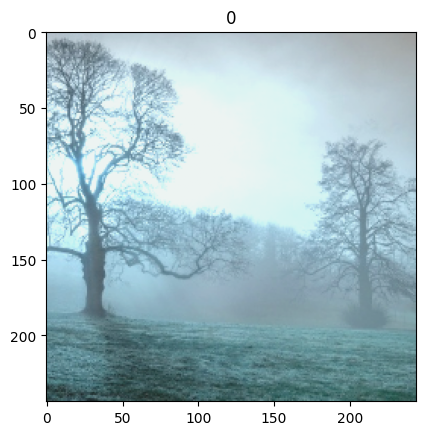

In [33]:
import matplotlib.pyplot as plt
idx=4000
plt.imshow(X_train[idx])
plt.title(y_train_labels[idx])
plt.show()

In [34]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 
    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    return delta_coord + delta_size

In [47]:
from tensorflow.keras.applications import VGG16  # type: ignore
vgg = VGG16()
vgg.save_weights('vgg16_weights.weights.h5')
print("Weights saved successfully!")

Weights saved successfully!


In [36]:
def build_model(): 
    input_layer = Input(shape=(244, 244, 3))
    vgg = VGG16(include_top=False, input_tensor=input_layer)
    f1 = GlobalMaxPooling2D()(vgg.output)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid', name='class_output')(class1)
    f2 = GlobalMaxPooling2D()(vgg.output)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid', name='bbox_output')(regress1)
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker
model = build_model()

In [37]:
classloss = BinaryCrossentropy()
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss={'class_output': classloss, 'bbox_output': localization_loss},
              metrics={'class_output': 'accuracy', 'bbox_output': 'mean_squared_error'})

In [38]:
t0 = time.time()
history = model.fit(X_train, [y_train_labels, y_train_bboxes],
                    validation_data=(X_val, [y_val_labels, y_val_bboxes]),
                    epochs=10, batch_size=32)
results = model.evaluate(X_test, [y_test_labels, y_test_bboxes])
print("Test Loss, Test Accuracy:", results)
t1 = time.time()
print(f"Training time: {t1 - t0} seconds")
model.save('TrainedFaceRecognition.h5')

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 931s 10s/step - bbox_output_mean_squared_error: 0.1058 - class_output_accuracy: 0.5196 - loss: 16.5070 - val_bbox_output_mean_squared_error: 0.1002 - val_class_output_accuracy: 0.4992 - val_loss: 14.5232
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 922s 10s/step - bbox_output_mean_squared_error: 0.1003 - class_output_accuracy: 0.5139 - loss: 14.4665 - val_bbox_output_mean_squared_error: 0.1010 - val_class_output_accuracy: 0.5518 - val_loss: 14.5556
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 909s 10s/step - bbox_output_mean_squared_error: 0.0989 - class_output_accuracy: 0.4877 - loss: 14.3939 - val_bbox_output_mean_squared_error: 0.1006 - val_class_output_accuracy: 0.4908 - val_loss: 14.5332
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 930s 10s/step - bbox_output_mean_squared_error: 0.0983 - class_output_accuracy: 0.4866 - loss: 14.2747 - val_bbox_output_mean_squared_error: 0.1011 - val_class_output_accuracy: 0.4980 - val_loss: 14.5752
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━

Test Loss, Test Accuracy: [7.609382629394531, 0.10170242935419083, 0.5234987139701843]
Training time: 18550.751497983932 seconds


In [3]:
model = keras.models.load_model('TrainedFaceRecognition.h5')

In [18]:
predictions = model.predict(X_test)
label_predictions = predictions[0]
bbox_predictions = predictions[1]


24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 649ms/step


In [19]:
def visualize_predictions(images, true_labels, true_bboxes, pred_labels, pred_bboxes):
    c=0
    for img, true_label, true_bbox, pred_label, pred_bbox in zip(images, true_labels, true_bboxes, pred_labels, pred_bboxes):
        img_copy = img.copy()
        if(c==50): #test only 50 images
            break
        c=c+1
        # Scale bounding box coordinates back to image size
        true_x1 = int(true_bbox[0] * img.shape[1])
        true_y1 = int(true_bbox[1] * img.shape[0])
        true_x2 = int(true_bbox[2] * img.shape[1])
        true_y2 = int(true_bbox[3] * img.shape[0])
        
        pred_x1 = int(pred_bbox[0] * img.shape[1])
        pred_y1 = int(pred_bbox[1] * img.shape[0])
        pred_x2 = int(pred_bbox[2] * img.shape[1])
        pred_y2 = int(pred_bbox[3] * img.shape[0])
        # Draw true bounding box (green)
        if true_label == 1:
            cv.rectangle(img_copy, (true_x1, true_y1), (true_x2, true_y2), (0, 255, 0), 2)
        
        # Draw predicted bounding box (red)
        if pred_label > 0.5: 
            cv.rectangle(img_copy, (pred_x1, pred_y1), (pred_x2, pred_y2), (255, 0, 0), 2)
        cv.imshow('Prediction', img_copy)
        cv.waitKey(0)
    cv.destroyAllWindows()
visualize_predictions(X_test, y_test_labels, y_test_bboxes, label_predictions, bbox_predictions)